In [33]:
# python
import sys
import os
import importlib
# columnar analysis
import awkward as ak
from dask.distributed import Client
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) # fixme: there must be a better way to handle this...
from sidm.tools import sidm_processor, utilities, cutflow, scaleout
# always reload local modules to pick up changes during development
importlib.reload(sidm_processor)
importlib.reload(utilities)
importlib.reload(scaleout)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline

In [35]:
#fname = '~/local_data/tta_mAlp-0p35GeV_ctau-1e3mm_part-0.root'
samples = [
    "4mu_1000GeV_0p25GeV_0p002mm",
    "4mu_1000GeV_0p25GeV_0p02mm",
    "4mu_1000GeV_0p25GeV_0p2mm",
    "4mu_1000GeV_0p25GeV_1p0mm",
    "4mu_1000GeV_0p25GeV_2p0mm",
]
fileset = utilities.make_fileset(samples, "llpNanoAOD_v2")
# create events collection from single file
fname = fileset[samples[0]][0]
events = NanoEventsFactory.from_root(
    fname,
    schemaclass=NanoAODSchema,
).events()

/opt/conda/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_jetIdx => Jet
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FsrPhoton_muonIdx => Muon
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index

In [36]:
#from coffea.nanoevents.schemas.base import zip_forms
from coffea.nanoevents.methods import vector as cvec
from coffea.nanoevents.methods import nanoaod
#print(events.Muon)
#print([events.DSAMuon[x] for x in ["pt", "eta"]])
print(events.DSAMuon)
forms = {f : events.DSAMuon[f] for f in events.DSAMuon.fields}
events.DSAMuon = ak.zip(forms, with_name="Muon", behavior=nanoaod.behavior)
print(events.DSAMuon)
print(events.DSAMuon.nearest(events.Muon))

AttributeError: no field named 'DSAMuon'

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/awkward/highlevel.py#L1124)

In [37]:
runner = processor.Runner(
    executor=processor.IterativeExecutor(),
    #executor=processor.DaskExecutor(),
    #executor=processor.FuturesExecutor(),
    schema=NanoAODSchema,
    # maxchunks=1,
)

hist_menu = utilities.load_yaml("../configs/hist_collections.yaml")
hist_choice = "base"
collection = utilities.flatten(hist_menu[hist_choice]) #To change the histograms used, swap "base" for the other collections

p = sidm_processor.SidmProcessor(
    [
        "baseNoLj",
        #"barrelE_ID-DPhiIn",
    ],
    [hist_choice],
    lj_reco_choices=["0.4"],
    llpnanoaod=True,
)

output = runner.run(fileset, treename='Events', processor_instance=p)
out = output["out"]

Output()

TypeError: cannot unpack non-iterable NoneType object

In [6]:
#This defines a function to break down the samples and make individual subplots for each one.
#Fix: should set the specific range as a parameter. For now, it uses [ :1200j]. Could be an issue in the future.
def plotSamples(hists, channel, errorBars, densityPlot, sample_0=samples, fullBg=False):
    samples = []
    if channel == "2mu2e":
        for sample in sample_0:
            if sample[0] != '4':
                samples.append(sample)
    elif channel == "4mu":
        for sample in sample_0:
            if sample[0] != '2':
                samples.append(sample)
    else:
        for sample in sample_0:
            samples.append(sample)
    nplots = len(samples)
    nhists = len(hists)
    if (nplots <= 6): ncol, nrow = nplots, 1
    else: ncol, nrow = 6, (nplots-1)//6 + 1
    plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*9))
    plt.rcParams['font.size'] = 16
    DY_Flag = QCD_Flag = DB_Flag = TT_Flag = Tot_BG_Flag = False
    Tot_BG_Flag = not fullBg
    for i in range(nplots):
        plt.subplot(nrow, ncol, i+1)
        j = 0
        if "DY_Jets" in samples and DY_Flag == False:
            for j in range(nhists):
                utilities.plot(DY_Hists[hists[j]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                DY_Flag = True
        elif "QCD_Jets" in samples and QCD_Flag == False:
            for j in range(nhists):
                utilities.plot(QCD_Hists[hists[j]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                QCD_Flag = True
        elif "DiBoson_Jets" in samples and DB_Flag == False:
            for j in range(nhists):
                utilities.plot(DiBoson_Hists[hists[j]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                DB_Flag = True
        elif "TTJets" in samples and TT_Flag == False:
            for j in range(nhists):
                utilities.plot(TT_Hists[hists[j]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                TT_Flag = True
        elif "Total Background" in samples and Tot_BG_Flag == False:
            for j in range(nhists):
                utilities.plot(bg_Hists[hists[j]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                Tot_BG_Flag = True
        else:
            for j in range(nhists):
                utilities.plot(out[samples[i]]["hists"][hists[j]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
        plt.legend(hists)
        plt.title(samples[i])

In [7]:
#This function plots each histogram on a separate subplot, showing all samples on each subplot
def plotHists(hists, channel, errorBars, densityPlot, sample_0=samples, fullBg=False):
    samples = []
    if channel == "2mu2e":
        for sample in sample_0:
            if sample[0] != '4':
                samples.append(sample)
    elif channel == "4mu":
        for sample in sample_0:
            if sample[0] != '2':
                samples.append(sample)
    else:
        for sample in sample_0:
            samples.append(sample)
    nplots = len(hists)
    if (nplots <= 5): ncol, nrow = nplots, 1
    else: ncol, nrow = 4, (nplots-1)//4 + 1
    plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*9))
    plt.rcParams['font.size'] = 16
    for i in range(nplots):
        DY_Flag = QCD_Flag = DB_Flag = TT_Flag = Tot_BG_Flag = False
        plt.subplot(nrow, ncol, i+1)
        j = 0
        while j < len(samples):
            if "DY_Jets" in samples and DY_Flag == False:
                utilities.plot(DY_Hists[hists[i]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                DY_Flag = True
            elif "QCD_Jets" in samples and QCD_Flag == False:
                utilities.plot(QCD_Hists[hists[i]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                QCD_Flag = True
            elif "DiBoson_Jets" in samples and DB_Flag == False:
                utilities.plot(DiBoson_Hists[hists[i]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                DB_Flag = True
            elif "TTJets" in samples and TT_Flag == False:
                utilities.plot(TT_Hists[hists[i]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                TT_Flag = True
            elif "Total Background" in samples and Tot_BG_Flag == False:
                utilities.plot(bg_Hists[hists[i]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                Tot_BG_Flag = True
            else:
                utilities.plot(out[samples[j]]["hists"][hists[i]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
            j = j + 1
        plt.legend(samples)
        plt.title(hists[i])

In [8]:
hists = out[samples[0]]["hists"]

In [13]:
cutflows = []
for sample in samples:
    cutflows.append(out[sample]["cutflow"]["baseNoLj"])
cutflow.print_multi_table(cutflows, samples, fraction=False, unweighted=False, title="test")

test
-------------------------------------------------------------------------------------------------------------------------------------------------------------
cut name                    Total cuts:                Total cuts:                Total cuts:                 Total cuts:                 Total cuts:
                2mu2e_500GeV_5GeV_0p08mm    2mu2e_500GeV_5GeV_0p8mm    2mu2e_500GeV_5GeV_8p0mm    2mu2e_500GeV_5GeV_40p0mm    2mu2e_500GeV_5GeV_80p0mm
------------  --------------------------  -------------------------  -------------------------  --------------------------  --------------------------
No selection                   104815.00                   72183.00                   85777.00                    61743.00                    82029.00
PV filter                        4017.00                    2773.00                    3513.00                     2500.00                     3304.00



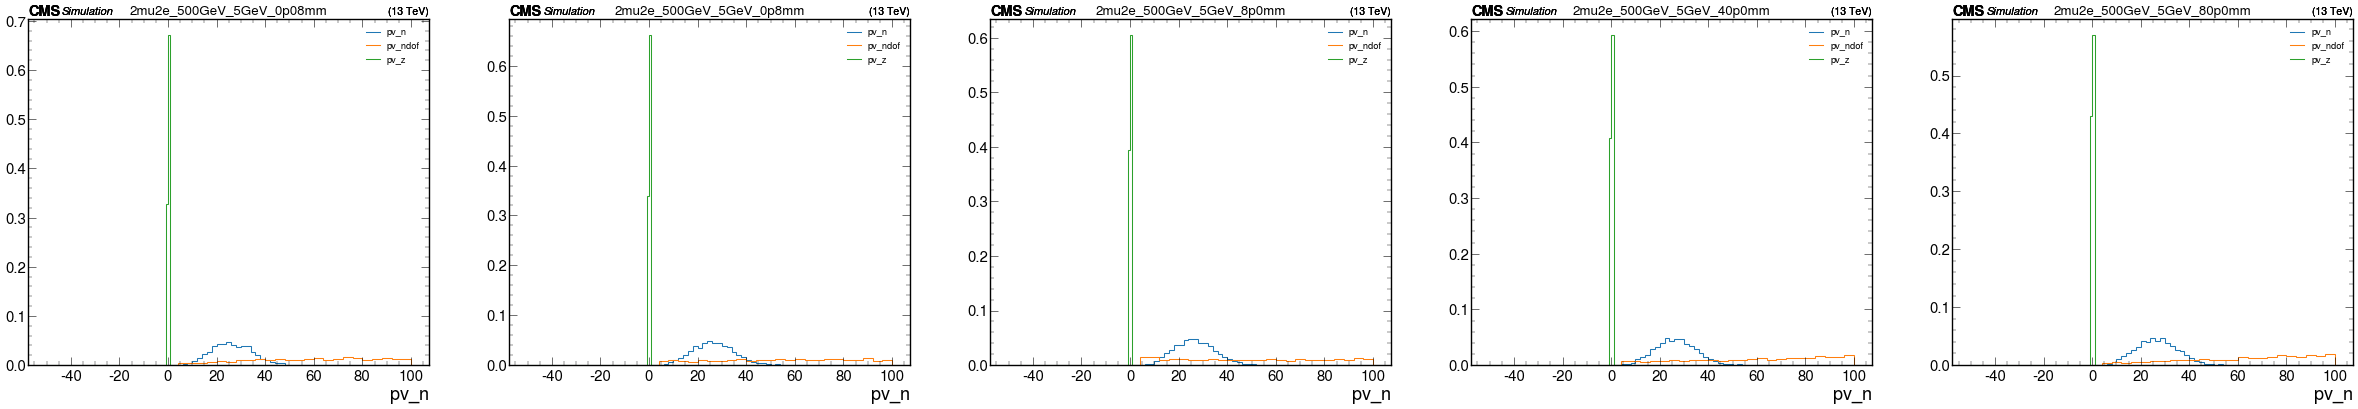

In [14]:
histlist = ["pv_n", "pv_ndof", "pv_z"]
plotSamples(histlist, "baseNoLj", False, True)

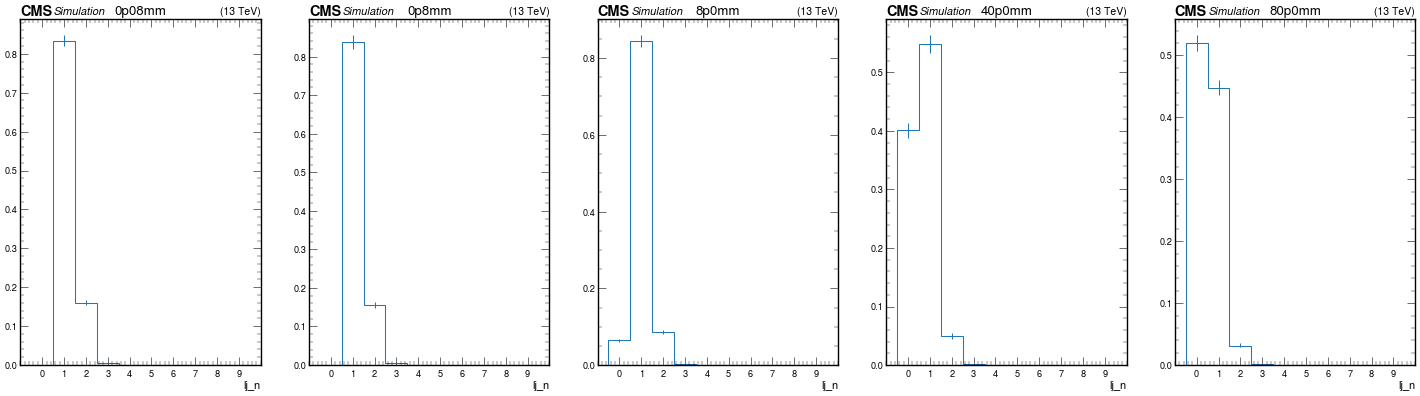

In [27]:
plt.subplots(1, 5, figsize=(36, 9))
for i in range(len(samples)):
    plt.subplot(1,5,i+1)
    utilities.plot(out[samples[i]]["hists"]["lj_n"]["baseNoLj", :10j], density=True)
    plt.title(samples[i].split("_")[-1])

In [32]:
for sample in samples:
    print(ak.num(events.lj))

AttributeError: no field named 'lj'

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/awkward/highlevel.py#L1124)